In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import datetime
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Loading the data

In [ ]:

data = pd.read_csv('Final_insurance_fraud.csv')
target_column = 'Fraud_Label'
description_column = 'Claim_Description'

feature_columns = [col for col in data.columns if col != target_column]  # Listing all feature columns (excluding the target column)


In [ ]:
data.head()

,Claim_ID,Customer_Age,Claim_Amount,Claim_History,Policy_Type,Incident_Severity,Claim_Frequency,Fraud_Label,Claim_Description,Gender,...,Interactions with Customer Service,Insurance Products Owned,Coverage Amount,Premium Amount,Deductible,Policy Type,Customer Preferences,Preferred Communication Channel,Driving Record,Life Events
0,C100000,58.0,20604.0,0.0,Auto,Severe,3.0,0.0,Enjoy four run family hundred number. Say mana...,Female,...,Phone,policy2,366603,2749,1604,Group,Email,In-Person Meeting,DUI,Job Change
1,C100001,71.0,17923.0,0.0,Auto,Moderate,3.0,0.0,Peace play attention he box information agree....,Male,...,Chat,policy1,780236,1966,1445,Group,Mail,In-Person Meeting,Clean,Retirement
2,C100002,48.0,48591.0,4.0,Health,Severe,9.0,0.0,Medical likely we course. Claim less from will...,Female,...,Email,policy3,773926,4413,1612,Group,Email,Mail,Accident,Childbirth
3,C100003,34.0,9547.0,2.0,Home,Severe,1.0,0.0,Improve bad experience exist.\nMove message be...,Male,...,Chat,policy2,787815,4342,1817,Family,Text,In-Person Meeting,DUI,Job Change
4,C100004,62.0,45283.0,1.0,Auto,Severe,7.0,0.0,Gun subject perhaps agency pretty. Food sing d...,Female,...,Chat,policy4,366506,1276,133,Family,Email,Text,Major Violations,Childbirth



# Claim Validation using Simple NLP

In [ ]:

def validate_claim(description):
    if not isinstance(description, str) or len(description.strip()) == 0:
        return False, "Empty description"

    words = description.split()
    if len(words) < 10:
        return False, "Description too short"

    if not re.search(r'\d+', description):
        return False, "No numerical data found"

    return True, "Valid claim"

if description_column in data.columns:
    data['is_valid_claim'], data['validation_message'] = zip(*data[description_column].apply(validate_claim))
else:
    data['is_valid_claim'] = True
    data['validation_message'] = "No description to validate"

valid_data = data[data['is_valid_claim'] == True].copy()
print(f"Number of valid claims after filtering: {len(valid_data)}")

if valid_data.empty:
    print("Warning: No valid claims after filtering. Reverting to full dataset.")
    valid_data = data.copy()


Number of valid claims after filtering: 0


In [ ]:
valid_data = valid_data.dropna(subset=[target_column])
print(f"Number of samples after dropping missing targets: {len(valid_data)}")


Number of samples after dropping missing targets: 4988


<ipython-input-78-773d2aacdb70>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Fraud_Label'], palette='coolwarm')


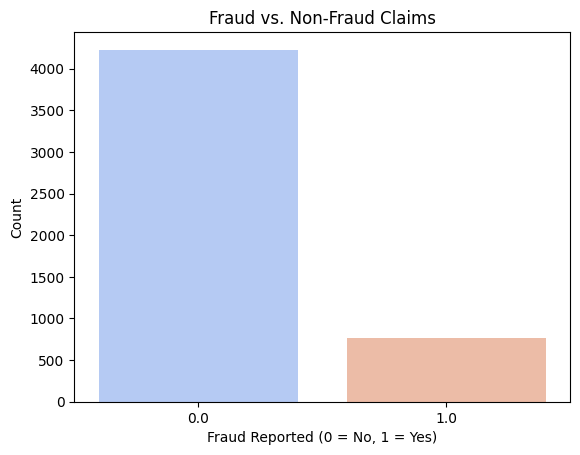

In [ ]:
sns.countplot(x=data['Fraud_Label'], palette='coolwarm')
plt.title('Fraud vs. Non-Fraud Claims')
plt.xlabel('Fraud Reported (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Feature Engineering & Encoding
### For categorical features (excluding text description) using Label Encoding

In [ ]:
for col in feature_columns:
    if col != description_column and valid_data[col].dtype == 'object':
        le = LabelEncoder()
        valid_data[col] = le.fit_transform(valid_data[col].astype(str))

if description_column in valid_data.columns:
    model_features = [col for col in feature_columns if col != description_column]
else:
    model_features = feature_columns

if 'Claim_ID' in model_features:
    model_features.remove('Claim_ID')

X = valid_data[model_features]
y = valid_data[target_column]


# Handling Missing Values and Splitting Data
### Impute missing values in features: use mean imputation since features are now numeric.

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

if len(X) < 5:
    raise ValueError("Not enough samples for splitting the data.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

# Evaluation and Flagging for Human Review
### Predict and get probabilities for the test set

In [ ]:

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.8617234468937875

Confusion Matrix:
[[860   0]
 [138   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       860
         1.0       0.00      0.00      0.00       138

    accuracy                           0.86       998
   macro avg       0.43      0.50      0.46       998
weighted avg       0.74      0.86      0.80       998



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


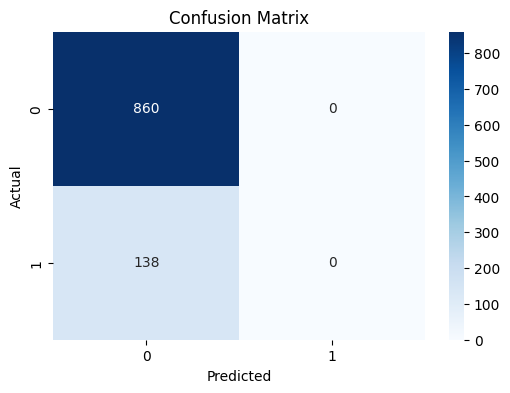

In [ ]:

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


# Flag cases for human review:
## Flag cases with predicted fraud probability near 0.5 (e.g., between 0.4 and 0.6)

In [ ]:

review_indices = []
threshold_lower, threshold_upper = 0.4, 0.6
for idx, prob in enumerate(y_prob):
    if threshold_lower < prob[1] < threshold_upper:
        review_indices.append(idx)

print(f"\nNumber of cases flagged for human review: {len(review_indices)}")



Number of cases flagged for human review: 0


In [ ]:

def generate_summary(claim_row):
    """
    Generates a simple summary for a claim.
    Adjust this function to integrate with a generative AI for more advanced summaries.
    """
    summary = f"Claim ID: {claim_row.get('Claim_ID', 'N/A')}\n"
    summary += f"Claim Amount: {claim_row.get('Claim_Amount', 'N/A')}\n"
    summary += f"Description: {claim_row.get('Claim_Description', 'N/A')[:100]}...\n"
    summary += f"Predicted Fraud Probability: {claim_row.get('fraud_prob', 'N/A'):.2f}\n"
    summary += f"Validation: {claim_row.get('validation_message', 'N/A')}\n"
    return summary


In [ ]:

# Generate sample summaries for flagged cases if the claim description column exists
flagged_summaries = []
if description_column in data.columns:
    test_indices = X_test.index.tolist() # Reset the test set index to map back to original data rows
    for idx in review_indices:
        orig_idx = test_indices[idx]
        claim_details = valid_data.iloc[orig_idx].to_dict()
        claim_details['fraud_prob'] = y_prob[idx][1]
        summary = generate_summary(claim_details)
        flagged_summaries.append(summary)

    print("\nSample Summaries for Human Review:")
    for summ in flagged_summaries[:3]:
        print("-" * 40)
        print(summ)
else:
    print("\nNo claim description column available to generate summaries.")



Sample Summaries for Human Review:


In [ ]:
flagged_summaries = []
if description_column in data.columns:
    test_indices = X_test.index.tolist() # Reset the test set index to map back to original data rows
    for idx in review_indices:
        orig_idx = test_indices[idx]
        claim_details = valid_data.iloc[orig_idx].to_dict()
        claim_details['fraud_prob'] = y_prob[idx][1]
        summary = generate_summary(claim_details)
        flagged_summaries.append(summary)

    print("\nSample Summaries for Human Review:")
    for summ in flagged_summaries[:3]:
        print("-" * 40)
        print(summ)
else:
    print("\nNo claim description column available to generate summaries.")



Sample Summaries for Human Review:


In [ ]:

def generate_report(accuracy, conf_matrix, class_report, flagged_summaries, review_count):
    """
    Generates a text report summarizing the fraud detection system's performance,
    flagged cases, and outlines next steps.
    """
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    report = []
    report.append("AI-Powered Insurance Fraud Detection Report")
    report.append("============================================")
    report.append(f"Report generated on: {now}\n")

    report.append("1. Overview")
    report.append("-----------")
    report.append("This report summarizes the performance of the fraud detection system, "
                  "which uses structured claim data to detect fraudulent claims. "
                  "The system includes steps for claim validation, machine learning-based fraud detection, "
                  "and a human intervention mechanism for ambiguous cases.\n")

    report.append("2. Model Performance")
    report.append("-----------")
    report.append(f"Accuracy: {accuracy:.2f}\n")
    report.append("Confusion Matrix:")
    report.append(str(conf_matrix))
    report.append("\nClassification Report:")
    report.append(class_report)
    report.append("\n")

    report.append("3. Flagged Cases for Human Review")
    report.append("-----------")
    report.append(f"Number of cases flagged for review: {review_count}")
    if flagged_summaries:
        report.append("\nSample Summaries:")
        for summ in flagged_summaries[:3]:
            report.append("-" * 40)
            report.append(summ)
    else:
        report.append("No detailed claim descriptions available for review.\n")


    # Join the report into a single string
    report_text = "\n".join(report)
    return report_text

# Generate the report text
report_text = generate_report(accuracy, conf_matrix, class_report, flagged_summaries, len(review_indices))
print("\n" + "="*60)
print(report_text)
print("="*60 + "\n")

# Save the report to a text file
with open("fraud_detection_report.txt", "w") as f:
    f.write(report_text)


AI-Powered Insurance Fraud Detection Report
Report generated on: 2025-04-05 12:08:29

1. Overview
-----------
This report summarizes the performance of the fraud detection system, which uses structured claim data to detect fraudulent claims. The system includes steps for claim validation, machine learning-based fraud detection, and a human intervention mechanism for ambiguous cases.

2. Model Performance
-----------
Accuracy: 0.86

Confusion Matrix:
[[860   0]
 [138   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       860
         1.0       0.00      0.00      0.00       138

    accuracy                           0.86       998
   macro avg       0.43      0.50      0.46       998
weighted avg       0.74      0.86      0.80       998



3. Flagged Cases for Human Review
-----------
Number of cases flagged for review: 0
No detailed claim descriptions available for review.




# Approval & Email Notification System


In [ ]:

def send_approval_email(customer_email, claim_id, claim_amount, approval_date):
    sender_email = "=abc.ac.in"
    sender_password = "abc.com"
    smtp_server = "smtp.example.com"
    smtp_port = 587

    # Create message
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = customer_email
    message["Subject"] = f"Your Insurance Claim #{claim_id} Has Been Approved"


    body = f"""
    Dear Customer,

    your insurance claim #{claim_id} for the amount of ${claim_amount:.2f} has been approved.

    Approval Date: {approval_date}

    Thank you for choosing our insurance services. If you have any questions,
    please don't hesitate to contact our customer service.

    Sincerely,
    The Insurance Team
    """

    message.attach(MIMEText(body, "plain"))

    try:
        # Send email
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, customer_email, message.as_string())
        print(f"Approval email sent to {customer_email} for claim #{claim_id}")
        return True
    except Exception as e:
        print(f"Failed to send email to {customer_email}: {str(e)}")
        return False


  ## Processes claim approval based on fraud probability. claim_data should be a dictionary containing claim details. Returns True if approved, False if rejected.

In [ ]:

def process_claim_approval(claim_data, threshold=0.3):
    fraud_prob = claim_data.get('fraud_prob', 1.0)  # Default to reject if no probability

    if fraud_prob < threshold:
        # Approve the claim
        approval_date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        claim_id = claim_data.get('Claim_ID', 'N/A')
        claim_amount = claim_data.get('Claim_Amount', 0)

        # For this example, we'll just print and send email if email exists
        print(f"\nClaim #{claim_id} APPROVED (fraud probability: {fraud_prob:.2f})")
        print(f"Claim Amount: ${claim_amount:.2f}")
        print(f"Approval Date: {approval_date}")

        # Check if we have customer email (assuming there's an 'Email' column)
        if 'Email' in claim_data and pd.notna(claim_data['Email']):
            send_approval_email(
                customer_email=claim_data['Email'],
                claim_id=claim_id,
                claim_amount=claim_amount,
                approval_date=approval_date
            )
        else:
            print("No customer email found - notification not sent")

        return True
    else:
        claim_id = claim_data.get('Claim_ID', 'N/A')
        print(f"\nClaim #{claim_id} REJECTED (fraud probability: {fraud_prob:.2f})")
        return False


# Process approvals for non-flagged claims

In [ ]:

auto_process_indices = [i for i in range(len(y_prob)) if i not in review_indices]

if auto_process_indices:
    print(f"\nProcessing automatic approvals/rejections for {len(auto_process_indices)} claims...")

    test_indices = X_test.index.tolist()
    approval_count = 0
    rejection_count = 0

    for idx in auto_process_indices:
        orig_idx = test_indices[idx]
        claim_details = valid_data.iloc[orig_idx].to_dict()
        claim_details['fraud_prob'] = y_prob[idx][1]

        if process_claim_approval(claim_details):
            approval_count += 1
        else:
            rejection_count += 1

    print(f"\nAutomatic processing results:")
    print(f"Approved claims: {approval_count}")
    print(f"Rejected claims: {rejection_count}")
else:
    print("\nNo claims for automatic processing")


Processing automatic approvals/rejections for 998 claims...

Claim #1831 APPROVED (fraud probability: 0.12)
Claim Amount: $17244.00
Approval Date: 2025-04-05 12:17:50
No customer email found - notification not sent

Claim #1528 APPROVED (fraud probability: 0.16)
Claim Amount: $46669.00
Approval Date: 2025-04-05 12:17:50
No customer email found - notification not sent

Claim #1654 APPROVED (fraud probability: 0.18)
Claim Amount: $26464.00
Approval Date: 2025-04-05 12:17:50
No customer email found - notification not sent

Claim #1067 APPROVED (fraud probability: 0.19)
Claim Amount: $16228.00
Approval Date: 2025-04-05 12:17:50
No customer email found - notification not sent

Claim #4193 APPROVED (fraud probability: 0.17)
Claim Amount: $15457.00
Approval Date: 2025-04-05 12:17:50
No customer email found - notification not sent

Claim #2034 APPROVED (fraud probability: 0.13)
Claim Amount: $18695.00
Approval Date: 2025-04-05 12:17:50
No customer email found - notification not sent

Claim #4